## Runtime Environment

* python >= 3.7
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

## Set Random seed

In [1]:
import torch
torch.manual_seed(42)

# Take a  view of dataset

In [2]:
import pandas as pd

dataset = pd.read_csv('../data/task2_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 2
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,THEORETICAL
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,THEORETICAL
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,ENGINEERING
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,EMPIRICAL
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,ENGINEERING


**Id**: 流水號  
**Title**: 論文標題  
**Abstract**: 論文摘要內容, 句子間以 **$$$** 分隔  
**Authors**: 論文作者  
**Categories**: 論文類別  
**Created date**: 論文上傳日期  
**Task 2**: 論文分類類別, 若句子有多個類別,以 **空格** 分隔 

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [3]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

In [4]:
dataset.head()

,Id,Abstract,Task 2
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING
3,D00004,Internet is the main source of information now...,EMPIRICAL
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING


## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validataion set.

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)

### For test data

In [6]:
dataset = pd.read_csv('../data/task2_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

### 統計單字 (Count words)  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  

在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
另外，我們也使用了`multiprocessing`來加速處理。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  
Also, we use `multiprocessing` to accelerate the process.

In [7]:
from multiprocessing import Pool
from nltk.tokenize import word_tokenize

def collect_words(data_path, n_workers=4):
    df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [8]:
words = set()
words |= collect_words('trainset.csv')

## Embedding class to save pretrained embedding

In [11]:
import re
import torch

class Embedding:
    """
    Args:
        embedding_path (str): Path where embedding are loaded from (text file).
        words (None or list): If not None, only load embedding of the words in
            the list.
        oov_as_unk (bool): If argument `words` are provided, whether or not
            treat words in `words` but not in embedding file as `<unk>`. If
            true, OOV will be mapped to the index of `<unk>`. Otherwise,
            embedding of those OOV will be randomly initialize and their
            indices will be after non-OOV.
        lower (bool): Whether or not lower the words.
        rand_seed (int): Random seed for embedding initialization.
    """

    def __init__(self, embedding_path,
                 words=None, oov_as_unk=True, lower=True, rand_seed=524):
        self.word_dict = {}
        self.vectors = None
        self.lower = lower
        self.extend(embedding_path, words, oov_as_unk)
        torch.manual_seed(rand_seed)

        if '<pad>' not in self.word_dict:
            self.add(
                '<pad>', torch.zeros(self.get_dim())
            )
        
        if '<bos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<bos>', t_tensor
            )
            
        if '<eos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eos>', t_tensor
            )
        
        if '<unk>' not in self.word_dict:
            self.add('<unk>')

    def to_index(self, word):
        """
        Args:
            word (str)

        Return:
             index of the word. If the word is not in `words` and not in the
             embedding file, then index of `<unk>` will be returned.
        """
        if self.lower:
            word = word.lower()

        if word not in self.word_dict:
            return self.word_dict['<unk>']
        else:
            return self.word_dict[word]

    def get_dim(self):
        return self.vectors.shape[1]

    def get_vocabulary_size(self):
        return self.vectors.shape[0]

    def add(self, word, vector=None):
        if self.lower:
            word = word.lower()

        if vector is not None:
            vector = vector.view(1, -1)
        else:
            vector = torch.empty(1, self.get_dim())
            torch.nn.init.uniform_(vector)
        self.vectors = torch.cat([self.vectors, vector], 0)
        self.word_dict[word] = len(self.word_dict)

    def extend(self, embedding_path, words, oov_as_unk=True):
        self._load_embedding(embedding_path, words)

        if words is not None and not oov_as_unk:
            # initialize word vector for OOV
            for word in words:
                if self.lower:
                    word = word.lower()

                if word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict)

            oov_vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict) - self.vectors.shape[0],
                            self.vectors.shape[1]))

            self.vectors = torch.cat([self.vectors, oov_vectors], 0)

    def _load_embedding(self, embedding_path, words):
        if words is not None:
            words = set(words)

        vectors = []

        with open(embedding_path) as fp:

            row1 = fp.readline()
            # if the first row is not header
            if not re.match('^[0-9]+ [0-9]+$', row1):
                # seek to 0
                fp.seek(0)
            # otherwise ignore the header

            for i, line in enumerate(fp):
                cols = line.rstrip().split(' ')
                word = cols[0]

                # skip word not in words if words are provided
                if words is not None and word not in words:
                    continue
                elif word not in self.word_dict:
                    self.word_dict[word] = len(self.word_dict)
                    vectors.append([float(v) for v in cols[1:]])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors


In [12]:
embedder = Embedding('../data/glove.6B.300d.txt', words)

In [13]:
import pickle

with open('embedding.pkl','wb') as f:
    pickle.dump(embedder, f)

pad: for padding  
unk: for word that didn't in our dicitonary

In [9]:
PAD_TOKEN = embedder.to_index("<pad>")
UNK_TOKEN = embedder.to_index("<unk>")
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words:
    word_dict[word]=len(word_dict)

In [10]:
import pickle

with open('dicitonary.pkl','wb') as f:
    pickle.dump(word_dict, f)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [16]:
from tqdm import tqdm_notebook as tqdm

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.to_index(word) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 2' in data:
        processed['Label'] = label_to_onehot(data['Task 2'])
        
    return processed

In [17]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', embedder, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', embedder, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('testset.csv', embedder, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [20]:
from torch.utils.data import Dataset
import torch

class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            
            # gather labels
            if 'Label' in data:
                batch_label.append(data['Label'])
                
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [21]:
trainData = AbstractDataset(train, PAD_TOKEN)
validData = AbstractDataset(valid, PAD_TOKEN)
testData = AbstractDataset(test, PAD_TOKEN)

# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 一層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and one fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(simpleNet, self).__init__()
        self.hidden_dim = 512
        self.sent_rnn = nn.GRU(vocabulary_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        
        self.layerNorm = nn.LayerNorm([self.hidden_dim*2])
        self.dropout = nn.Dropout(0.5)
        
        self.l1 = nn.Linear(self.hidden_dim, 4)
        
    def forward(self, x):
        b,s,w,e = x.shape
        x = x.view(b,s*w,e)
        x, __ = self.sent_rnn(x)
        x = self.layerNorm(x)
        x = self.dropout(x)
        x = x.view(b,s,w,-1)
        x = torch.max(x,dim=2)[0]
        x = x[:,:,:self.hidden_dim] + x[:,:,self.hidden_dim:]
        x = torch.max(x,dim=1)[0]
        x = torch.sigmoid(self.l1(F.relu(x)))
        return x

# Training

指定使用的運算裝置  
Designate running device.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [25]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.bool) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [26]:
import os
def _run_epoch(epoch, embedding, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=20,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        x = embedding(x)
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [27]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = simpleNet(embedder.get_dim())
opt = torch.optim.Adam(model.parameters(), lr=2e-4)
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 25
history = {'train':[],'valid':[]}


embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim())
embedding.weight = torch.nn.Parameter(embedder.vectors)


In [28]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, embedding, True)
    _run_epoch(epoch, embedding, False)
    save(epoch)

Epoch: 0


tensor([[0.5587, 0.4651, 0.3399, 0.4038],
        [0.5815, 0.4333, 0.3260, 0.4455],
        [0.5619, 0.4172, 0.3488, 0.4142],
        [0.5627, 0.4329, 0.3611, 0.4406],
        [0.5416, 0.4410, 0.3533, 0.4247],
        [0.5973, 0.4639, 0.3402, 0.4388],
        [0.5507, 0.4686, 0.3519, 0.4643],
        [0.5251, 0.4396, 0.3633, 0.4315],
        [0.5440, 0.4447, 0.3563, 0.4458],
        [0.5644, 0.4300, 0.3937, 0.4883],
        [0.5896, 0.4290, 0.3669, 0.4511],
        [0.5774, 0.4261, 0.3510, 0.4239],
        [0.5307, 0.4225, 0.3367, 0.4562],
        [0.5794, 0.4486, 0.3535, 0.4211],
        [0.5724, 0.4405, 0.3458, 0.4316],
        [0.5498, 0.4692, 0.3766, 0.4281],
        [0.5768, 0.4167, 0.3484, 0.4344],
        [0.5833, 0.4455, 0.3610, 0.4272],
        [0.5788, 0.4536, 0.3861, 0.4320],
        [0.5913, 0.4270, 0.3447, 0.4368]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
    

tensor([[0.3878, 0.2847, 0.2802, 0.0700],
        [0.3828, 0.3256, 0.2829, 0.0600],
        [0.3913, 0.3162, 0.2977, 0.0682],
        [0.3822, 0.2976, 0.2599, 0.0629],
        [0.3843, 0.3037, 0.2749, 0.0567],
        [0.3881, 0.3279, 0.2612, 0.0689],
        [0.4266, 0.3361, 0.2695, 0.0763],
        [0.3715, 0.3361, 0.2708, 0.0795],
        [0.4193, 0.2966, 0.2792, 0.0776],
        [0.3866, 0.3309, 0.2881, 0.0593],
        [0.4013, 0.3354, 0.2802, 0.0773],
        [0.3863, 0.2836, 0.2871, 0.0547],
        [0.4053, 0.3139, 0.2936, 0.0777],
        [0.3856, 0.2883, 0.2799, 0.0655],
        [0.3964, 0.3602, 0.2897, 0.0677],
        [0.4389, 0.3187, 0.3049, 0.0810],
        [0.3920, 0.3086, 0.3070, 0.0642],
        [0.3700, 0.3146, 0.2840, 0.0726],
        [0.4018, 0.3282, 0.2735, 0.0629],
        [0.3503, 0.3388, 0.2895, 0.0869]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
    

tensor([[0.4412, 0.5147, 0.3326, 0.0247],
        [0.4766, 0.5073, 0.3297, 0.0245],
        [0.4523, 0.5308, 0.3050, 0.0228],
        [0.4351, 0.4934, 0.2942, 0.0375],
        [0.4483, 0.5116, 0.3097, 0.0284],
        [0.4240, 0.5376, 0.3047, 0.0275],
        [0.4638, 0.5256, 0.3073, 0.0251],
        [0.4471, 0.4926, 0.3244, 0.0292],
        [0.4354, 0.5443, 0.3017, 0.0221],
        [0.4191, 0.5289, 0.3049, 0.0310],
        [0.4305, 0.5052, 0.3008, 0.0261],
        [0.4723, 0.4894, 0.3145, 0.0269],
        [0.4086, 0.5346, 0.3394, 0.0242],
        [0.4655, 0.5080, 0.2797, 0.0293],
        [0.4457, 0.5137, 0.2984, 0.0364],
        [0.4286, 0.4846, 0.2981, 0.0291],
        [0.4684, 0.5259, 0.3119, 0.0273],
        [0.4428, 0.5102, 0.3137, 0.0244],
        [0.4420, 0.5159, 0.3112, 0.0283],
        [0.4769, 0.5181, 0.3262, 0.0205]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
    

tensor([[0.4909, 0.5219, 0.3543, 0.0370],
        [0.5246, 0.5781, 0.3731, 0.0146],
        [0.5024, 0.4970, 0.3579, 0.0262],
        [0.4601, 0.5864, 0.4165, 0.0139],
        [0.4664, 0.5799, 0.4291, 0.0157],
        [0.4646, 0.5638, 0.4241, 0.0168],
        [0.4930, 0.5895, 0.4097, 0.0188],
        [0.4952, 0.5883, 0.4188, 0.0160],
        [0.4556, 0.5719, 0.3591, 0.0172],
        [0.4566, 0.5479, 0.3242, 0.0279],
        [0.5071, 0.5876, 0.3653, 0.0154],
        [0.4519, 0.5725, 0.3706, 0.0149],
        [0.5215, 0.5354, 0.3293, 0.0230],
        [0.4592, 0.5488, 0.3753, 0.0175],
        [0.4374, 0.5532, 0.4179, 0.0200],
        [0.4467, 0.5585, 0.3737, 0.0209],
        [0.4763, 0.5606, 0.3549, 0.0203],
        [0.5188, 0.6113, 0.4466, 0.0115],
        [0.5448, 0.5782, 0.4069, 0.0135],
        [0.4919, 0.5739, 0.3778, 0.0286]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
    

tensor([[0.4083, 0.4263, 0.3806, 0.0172],
        [0.4046, 0.4126, 0.3706, 0.0194],
        [0.4063, 0.4181, 0.3923, 0.0175],
        [0.4210, 0.4458, 0.3286, 0.0183],
        [0.4724, 0.4245, 0.3632, 0.0133],
        [0.4409, 0.3925, 0.3856, 0.0141],
        [0.3983, 0.4217, 0.3802, 0.0172],
        [0.4500, 0.3873, 0.3608, 0.0147],
        [0.4512, 0.4134, 0.3713, 0.0132],
        [0.4305, 0.4065, 0.3924, 0.0137],
        [0.3931, 0.4229, 0.3510, 0.0253],
        [0.4556, 0.4147, 0.3231, 0.0148],
        [0.4608, 0.4165, 0.3586, 0.0117],
        [0.3678, 0.4326, 0.3724, 0.0124],
        [0.4219, 0.3796, 0.3554, 0.0181],
        [0.4459, 0.4513, 0.3474, 0.0194],
        [0.4171, 0.4182, 0.3230, 0.0216],
        [0.4470, 0.4010, 0.3477, 0.0199],
        [0.4113, 0.4377, 0.3663, 0.0155],
        [0.4318, 0.3951, 0.3772, 0.0187]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
    

tensor([[0.4634, 0.4060, 0.3126, 0.0163],
        [0.4446, 0.4006, 0.3026, 0.0141],
        [0.5090, 0.3708, 0.2897, 0.0178],
        [0.3975, 0.3646, 0.3204, 0.0169],
        [0.4406, 0.3922, 0.3050, 0.0234],
        [0.4315, 0.3869, 0.2975, 0.0208],
        [0.4279, 0.3749, 0.3128, 0.0207],
        [0.4517, 0.3585, 0.3131, 0.0143],
        [0.4165, 0.4105, 0.2699, 0.0177],
        [0.4370, 0.4015, 0.2864, 0.0171],
        [0.4621, 0.3859, 0.3044, 0.0162],
        [0.4284, 0.3984, 0.3181, 0.0179],
        [0.4427, 0.4133, 0.2812, 0.0169],
        [0.4678, 0.4032, 0.2881, 0.0151],
        [0.4281, 0.3961, 0.2915, 0.0124],
        [0.4866, 0.3574, 0.2742, 0.0210],
        [0.4797, 0.3426, 0.2464, 0.0192],
        [0.4318, 0.4246, 0.2467, 0.0177],
        [0.4772, 0.3936, 0.2772, 0.0199],
        [0.4492, 0.3771, 0.2987, 0.0252]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
    

tensor([[0.4260, 0.5507, 0.2693, 0.0217],
        [0.4826, 0.4625, 0.2299, 0.0229],
        [0.5055, 0.5111, 0.2496, 0.0143],
        [0.4688, 0.4639, 0.2778, 0.0266],
        [0.4287, 0.4884, 0.2712, 0.0211],
        [0.4242, 0.5462, 0.2867, 0.0127],
        [0.4465, 0.5623, 0.2843, 0.0140],
        [0.3997, 0.5034, 0.3007, 0.0137],
        [0.4959, 0.5112, 0.2460, 0.0160],
        [0.4247, 0.5370, 0.2774, 0.0155],
        [0.4416, 0.5259, 0.2837, 0.0243],
        [0.4358, 0.5220, 0.2983, 0.0231],
        [0.4374, 0.5638, 0.2573, 0.0184],
        [0.5391, 0.4680, 0.2081, 0.0291],
        [0.4478, 0.5325, 0.2810, 0.0156],
        [0.4909, 0.4766, 0.2715, 0.0223],
        [0.5687, 0.4418, 0.2293, 0.0186],
        [0.4013, 0.5106, 0.2982, 0.0179],
        [0.4189, 0.4599, 0.2658, 0.0185],
        [0.3954, 0.5051, 0.2695, 0.0314]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
    

tensor([[0.4246, 0.4773, 0.3043, 0.0249],
        [0.4009, 0.4785, 0.3266, 0.0311],
        [0.3447, 0.5314, 0.3593, 0.0175],
        [0.3828, 0.5126, 0.3655, 0.0303],
        [0.4695, 0.4470, 0.2705, 0.0228],
        [0.4509, 0.4477, 0.3273, 0.0131],
        [0.4165, 0.4586, 0.3285, 0.0246],
        [0.3801, 0.4812, 0.3935, 0.0428],
        [0.3232, 0.5161, 0.3401, 0.0286],
        [0.4025, 0.4678, 0.3189, 0.0190],
        [0.4362, 0.4817, 0.3190, 0.0184],
        [0.4020, 0.5241, 0.3223, 0.0207],
        [0.3242, 0.5274, 0.3823, 0.0156],
        [0.4919, 0.4303, 0.3225, 0.0225],
        [0.4323, 0.4499, 0.3053, 0.0224],
        [0.4125, 0.4658, 0.3275, 0.0208],
        [0.4468, 0.4350, 0.3292, 0.0231],
        [0.3543, 0.5219, 0.3573, 0.0180],
        [0.3890, 0.5033, 0.3444, 0.0291],
        [0.3337, 0.4960, 0.3710, 0.0277]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 1., 0.],
    

tensor([[0.4870, 0.4486, 0.2710, 0.0247],
        [0.4222, 0.4881, 0.2996, 0.0315],
        [0.3782, 0.4675, 0.3328, 0.0489],
        [0.3719, 0.4578, 0.3099, 0.0318],
        [0.3708, 0.4771, 0.3764, 0.0557],
        [0.4815, 0.4247, 0.2889, 0.0295],
        [0.4030, 0.4948, 0.3393, 0.0382],
        [0.3973, 0.5497, 0.3132, 0.0347],
        [0.3984, 0.4834, 0.3372, 0.0329],
        [0.3823, 0.4770, 0.3222, 0.0346],
        [0.4375, 0.4802, 0.2800, 0.0293],
        [0.4606, 0.4425, 0.2771, 0.0291],
        [0.3301, 0.5223, 0.2910, 0.0465],
        [0.3918, 0.4916, 0.3022, 0.0318],
        [0.5364, 0.4550, 0.2437, 0.0317],
        [0.4795, 0.4379, 0.2631, 0.0287],
        [0.4398, 0.4906, 0.2443, 0.0245],
        [0.5516, 0.4157, 0.2687, 0.0277],
        [0.3341, 0.5084, 0.2972, 0.0261],
        [0.3605, 0.5252, 0.3176, 0.0381]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
    

tensor([[0.4821, 0.5392, 0.2713, 0.0380],
        [0.4064, 0.4789, 0.3796, 0.0417],
        [0.4212, 0.5495, 0.3458, 0.0422],
        [0.4417, 0.4382, 0.3521, 0.0506],
        [0.3552, 0.5313, 0.3453, 0.0427],
        [0.4644, 0.4871, 0.3018, 0.0354],
        [0.4480, 0.5064, 0.3133, 0.0504],
        [0.4290, 0.5086, 0.3254, 0.0398],
        [0.3958, 0.5008, 0.3344, 0.0488],
        [0.4399, 0.5517, 0.3113, 0.0477],
        [0.4071, 0.4992, 0.3678, 0.0447],
        [0.4555, 0.4736, 0.2928, 0.0383],
        [0.4895, 0.4429, 0.3039, 0.0426],
        [0.5567, 0.4537, 0.2824, 0.0428],
        [0.6941, 0.3824, 0.2123, 0.0420],
        [0.3981, 0.4673, 0.3751, 0.0444],
        [0.4665, 0.5018, 0.3029, 0.0390],
        [0.4714, 0.4557, 0.3466, 0.0561],
        [0.4076, 0.5038, 0.3376, 0.0497],
        [0.4391, 0.5229, 0.3516, 0.0359]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 1., 0.],
        [0., 0., 0., 1.],
    

tensor([[0.3945, 0.5679, 0.2989, 0.0475],
        [0.5490, 0.4010, 0.3084, 0.0749],
        [0.4147, 0.5522, 0.3652, 0.0385],
        [0.4404, 0.4672, 0.3765, 0.0593],
        [0.5313, 0.5312, 0.2758, 0.0355],
        [0.6369, 0.4762, 0.2346, 0.0493],
        [0.4597, 0.4725, 0.3417, 0.0457],
        [0.5047, 0.5079, 0.3171, 0.0513],
        [0.3697, 0.5969, 0.3426, 0.0475],
        [0.5697, 0.5270, 0.2807, 0.0314],
        [0.3686, 0.5745, 0.4070, 0.0473],
        [0.4505, 0.5633, 0.3410, 0.0475],
        [0.4813, 0.5613, 0.3131, 0.0305],
        [0.4697, 0.4707, 0.3365, 0.0489],
        [0.4292, 0.5203, 0.3809, 0.0511],
        [0.4827, 0.5272, 0.3131, 0.0488],
        [0.4095, 0.4136, 0.3809, 0.0934],
        [0.6387, 0.4109, 0.2506, 0.0449],
        [0.4322, 0.5196, 0.3635, 0.0459],
        [0.4701, 0.5206, 0.3112, 0.0432]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
    

tensor([[0.4291, 0.5721, 0.2848, 0.0478],
        [0.4143, 0.6099, 0.3348, 0.0563],
        [0.4871, 0.6619, 0.2406, 0.0431],
        [0.4412, 0.5051, 0.3204, 0.0556],
        [0.3465, 0.6448, 0.3219, 0.0451],
        [0.5029, 0.5530, 0.2586, 0.0420],
        [0.4103, 0.5355, 0.3101, 0.0774],
        [0.4283, 0.4924, 0.3189, 0.0835],
        [0.3965, 0.6499, 0.2795, 0.0452],
        [0.4776, 0.6271, 0.2983, 0.0292],
        [0.6254, 0.5419, 0.1687, 0.0310],
        [0.4129, 0.6324, 0.2756, 0.0462],
        [0.4181, 0.6571, 0.2867, 0.0401],
        [0.4582, 0.6282, 0.2430, 0.0306],
        [0.4301, 0.4983, 0.3198, 0.0839],
        [0.3892, 0.6950, 0.2787, 0.0421],
        [0.4057, 0.5864, 0.3001, 0.0461],
        [0.3927, 0.7160, 0.3165, 0.0303],
        [0.4344, 0.6427, 0.2773, 0.0420],
        [0.7169, 0.3648, 0.1807, 0.0360]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 1., 0.],
    

tensor([[0.3393, 0.5758, 0.3335, 0.0528],
        [0.3377, 0.6022, 0.3547, 0.0414],
        [0.2666, 0.6875, 0.3337, 0.0359],
        [0.5466, 0.4921, 0.2007, 0.0296],
        [0.3044, 0.6803, 0.3118, 0.0464],
        [0.5433, 0.5226, 0.2050, 0.0254],
        [0.2791, 0.6394, 0.3528, 0.0347],
        [0.2874, 0.5750, 0.3580, 0.0632],
        [0.3827, 0.6678, 0.2804, 0.0358],
        [0.3735, 0.6250, 0.2773, 0.0267],
        [0.3332, 0.5418, 0.3555, 0.0703],
        [0.3179, 0.6179, 0.3246, 0.0437],
        [0.3925, 0.5201, 0.3011, 0.0426],
        [0.2470, 0.7420, 0.3404, 0.0278],
        [0.3216, 0.6076, 0.2813, 0.0415],
        [0.3884, 0.6497, 0.2698, 0.0285],
        [0.2659, 0.6476, 0.3153, 0.0549],
        [0.4004, 0.6150, 0.2826, 0.0377],
        [0.2430, 0.7121, 0.3552, 0.0370],
        [0.3494, 0.6272, 0.2898, 0.0342]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 0.],
    

tensor([[0.4255, 0.5770, 0.3992, 0.0384],
        [0.4495, 0.6032, 0.3739, 0.0349],
        [0.3789, 0.6801, 0.4149, 0.0225],
        [0.4390, 0.5802, 0.4020, 0.0425],
        [0.5167, 0.6494, 0.3328, 0.0277],
        [0.4308, 0.6314, 0.3684, 0.0282],
        [0.4128, 0.4787, 0.4204, 0.0626],
        [0.6250, 0.4507, 0.2549, 0.0399],
        [0.4151, 0.5676, 0.4392, 0.0404],
        [0.4283, 0.5613, 0.3873, 0.0379],
        [0.3535, 0.5660, 0.4305, 0.0462],
        [0.3104, 0.6000, 0.4245, 0.0475],
        [0.3724, 0.6536, 0.4003, 0.0394],
        [0.4657, 0.4687, 0.4157, 0.0443],
        [0.6930, 0.3674, 0.2821, 0.0304],
        [0.3445, 0.7106, 0.3868, 0.0292],
        [0.5202, 0.4618, 0.3085, 0.0484],
        [0.3675, 0.6534, 0.3911, 0.0334],
        [0.4378, 0.6036, 0.3832, 0.0279],
        [0.3878, 0.6618, 0.4032, 0.0335]], device='cuda:0',
       grad_fn=<SigmoidBackward>) tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
    

KeyboardInterrupt: 

# Plot

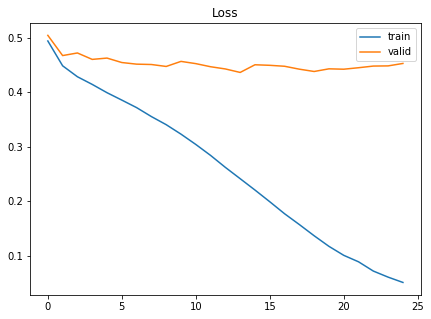

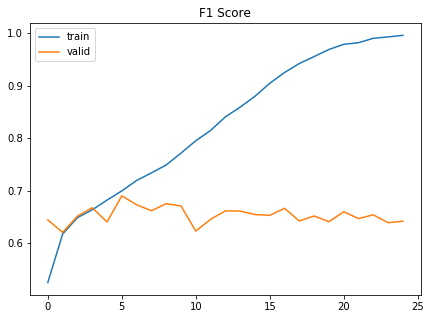

Best F1 score  [0.6901027582477015, 5]


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

## Predict

In [34]:
model.load_state_dict(torch.load('model/model.pkl.{}'.format(5)))
model.train(False)
_run_epoch(1, embedding, False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x,y,_l) in trange:
    x = embedding(x)
    o_labels = model(x.to(device))
    o_labels = o_labels>0.5
    prediction.append(o_labels.to('cpu'))

prediction = torch.cat(prediction).detach().numpy().astype(int)

In [35]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [41]:
SubmitGenerator(prediction, 
                '../data/task2_sample_submission.csv',
                True, 
                '../score/task2/task2_submission.csv')